# Analyse Fisher matrix generate using [s1_get_fisher_matrix.ipynb](s1_get_fisher_matrix.ipynb) and get
* ## Total kSZ SNR.
* ## Reionisation constraints.

In [15]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np, sys, os, scipy as sc, warnings
sys.path.append('modules/')
import tools, ilc, fisher_tools, tools_for_plotting
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *

import copy

In [17]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


# Experiment names and $f_{\rm sky}$ values

In [18]:
#experiment names and fsky values
expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp', 's4_wide', 's4_deep']
exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  #'s4_wide_withccatp': ['S4-Wide + FYST', 0.5], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G+SPT-4', 0.03, 'tab:green'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline + FYST', 0.4, 'tab:blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal + FYST', 0.4, 'tab:orange'], 
                  }

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

In [19]:
#read the Fisher matrix first
if (1): #TTEETE-only
    fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ_TTEETE_3mJymask.npy'
    expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp', 's4_wide', 's4_deep']
    #expname_arr = ['s4_wide']

if (0): #TT-only
    fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ_TT_3mJymask.npy'
    expname_arr = ['s4_wide']

if (0): #TT-only
    fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ_TTEETE_1mJymask.npy'
    expname_arr = ['s4_wide']
    
parent_F_dict = np.load( fisher_fname, allow_pickle=True).item()
print(parent_F_dict.keys() ) #different lmax_TT

##############
#different ILC
ilcname_arr = ['MV', 'cross-ILC']
##############

##############
#lmax TT
max_l_temp_for_ksz_arr = [3000, 3500, 4000, 4500, 5000]
##############

##############
#fiducial parameters values
param_dict = tools_for_plotting.get_ini_param_dict()
#print(param_dict.keys())
##############

###############
#priors
tau_prior_planck = 0.007
tau_prior_litebird = 0.002
spec_index_radio_prior = 0.1 #Radio spectral index prior
spec_index_radio_scatter_prior = 0.3 #Radio spectral index scatter prior
Aksz_h_prior = 0.1
alphaksz_h_prior = 0.1
Acibtsz_prior = 0.1

planck_prior_dic = {'ombh2': 0.00015, 'omch2': 0.0012, 'As': 2.9063421874997835e-11, 'ns':  0.0042, 'thetastar':0.00031/100.}
###############

dict_keys(['lmax_5000', 'lmax_6000', 'lmax_7000'])


In [21]:
#print total kSZ SNR now

reqd_max_l_temp = 5000
#reqd_max_l_temp = 6000
reqd_max_l_temp_keyname = 'lmax_%s' %(reqd_max_l_temp)
F_dict = parent_F_dict[reqd_max_l_temp_keyname]
print(F_dict.keys()) #different experiments


print_constraints = True #False #True
desired_param = 'Aksz'
#for iter in range(0, 3):
param_dic = {}
#for iter in [1, 3, 4]:
#for iter in [1, 4, 5]:
#for iter in [0, 1, 4, 5]:
#for iter in [1, 3]:
for iter in [1]:
    param_dic[iter] = {}
    print('\n##########################')
    #fix params
    if iter == 0: #fix radio/CIB+tSZ
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma', 'Acibtsz']
        prior_dic = {'tau':0.007, #Planck tau prior
                    }
    elif iter == 1: #fix radio; Free CIB+tSZ with xx prior.
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma']
        prior_dic = {'tau':0.007, #Planck tau prior
                     'Acibtsz': Acibtsz_prior,
                    }
    elif iter == 2: #fix radio; Free CIB+tSZ with no prior.
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma']
        prior_dic = {'tau':0.007, #Planck tau prior
                    }
    elif iter == 3: #free radio, CIB+tSZ with priors.
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur']
        prior_dic = {'tau':0.007, #Planck tau prior
                     'alpha_radio': spec_index_radio_prior, 
                     'alpha_radio_sigma': spec_index_radio_scatter_prior,
                     'Acibtsz': Acibtsz_prior,
                    }
    elif iter == 4: #Planck prior
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma', 'Acibtsz']
        prior_dic = {'tau':0.007, #Planck tau prior
                    }
        for ppp in planck_prior_dic:
            prior_dic[ppp] = planck_prior_dic[ppp]

    elif iter == 5: #fix LCDM + foreground parameters.
        fix_params = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma', 'Acibtsz', 
                     'ombh2', 'omch2', 'As', 'ns', 'thetastar']
        
        prior_dic = {'tau':0.007, #Planck tau prior
                    }

    print('\n Parameters fixed = %s' %(fix_params))
    for expname in expname_arr:
    #for expname in ['spt3g']:
        param_dic[iter][expname] = {}
        if print_constraints: print('\tExperiment = %s' %(expname))
        latex_str = ''
        for max_l_temp_for_ksz in max_l_temp_for_ksz_arr:
            param_dic[iter][expname][max_l_temp_for_ksz] = {}
            for ilcname in ilcname_arr:                
                fisher_keyname = (max_l_temp_for_ksz, reqd_max_l_temp)
                
                tmp_dict = F_dict[expname][ilcname]
                curr_F_mat, curr_param_names = tmp_dict[fisher_keyname]
                #print(ilcname, fisher_keyname, curr_F_mat.shape, len(curr_param_names))
                
                sigma_Aksz = fisher_tools.get_sigma_of_a_parameter(curr_F_mat, curr_param_names, desired_param, prior_dic = prior_dic, fix_params_arr = fix_params)

                snr_Aksz = param_dict['Aksz']/sigma_Aksz
                if print_constraints:
                    print( '\t\tILC = %s; lmax for kSZ = %s; AkSZ SNR = %.2f' %(ilcname, max_l_temp_for_ksz, snr_Aksz) )
                latex_str = '%s & %.2f' %(latex_str, snr_Aksz); ##sys.exit()
                param_dic[iter][expname][max_l_temp_for_ksz][ilcname] = snr_Aksz
        
        latex_str = latex_str.strip(' & ')
        if print_constraints:
            print('\t', latex_str); ##sys.exit()
    print('##########################\n')

if (0):
    #if not print_constraints and len(param_dic)>1: #show ratios now
    if len(param_dic)>1: #show ratios now
        reqd_ilcname = 'cross-ILC'
        if (1): #radio
            #reqd_max_l_temp_for_ksz = 4000
            reqd_max_l_temp_for_ksz = 4500
            iter_val_1, iter_val_2 = [1, 3]
        if (0): #Planck-priors
            reqd_max_l_temp_for_ksz = 4500
            #iter_val_1, iter_val_2 = [1, 4]
            iter_val_1, iter_val_2 = [4, 0]
        for expname in expname_arr:
            val1 = param_dic[iter_val_1][expname][reqd_max_l_temp_for_ksz][reqd_ilcname]
            val2 = param_dic[iter_val_2][expname][reqd_max_l_temp_for_ksz][reqd_ilcname]
            print(expname, val1/val2)
    

dict_keys(['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp', 's4_wide', 's4_deep'])

##########################

 Parameters fixed = ['mnu', 'neff', 'ws', 'Aksz_h', 'alphaksz_h', 'zmid', 'zdur', 'alpha_radio', 'alpha_radio_sigma']
	Experiment = spt3g
		ILC = MV; lmax for kSZ = 3000; AkSZ SNR = 10.33
		ILC = cross-ILC; lmax for kSZ = 3000; AkSZ SNR = 8.39
		ILC = MV; lmax for kSZ = 3500; AkSZ SNR = 19.73
		ILC = cross-ILC; lmax for kSZ = 3500; AkSZ SNR = 12.94
		ILC = MV; lmax for kSZ = 4000; AkSZ SNR = 27.68
		ILC = cross-ILC; lmax for kSZ = 4000; AkSZ SNR = 16.55
		ILC = MV; lmax for kSZ = 4500; AkSZ SNR = 27.09
		ILC = cross-ILC; lmax for kSZ = 4500; AkSZ SNR = 19.11
		ILC = MV; lmax for kSZ = 5000; AkSZ SNR = 4.43
		ILC = cross-ILC; lmax for kSZ = 5000; AkSZ SNR = 20.85
	 10.33 & 8.39 & 19.73 & 12.94 & 27.68 & 16.55 & 27.09 & 19.11 & 4.43 & 20.85
	Experiment = spt4
		ILC = MV; lmax for kSZ = 3000; AkSZ SNR = 11.51
		ILC = cross-ILC; lmax for kS

dict_keys(['lmax_5000', 'lmax_6000', 'lmax_7000'])

##########################

 Parameters fixed = ['mnu', 'neff', 'ws', 'Aksz']
7.690114551901377 6.960606387119796 8.389949227889185 1.43

##########################

 Parameters fixed = ['mnu', 'neff', 'ws', 'Aksz']
7.690114551901377 7.484934214806317 7.892881661513909 0.41


/Users/sraghunathan/Research/SPTpol/analysis/2020_07/ksz_ps/for_cross_ilc_paper/cross_ilc_methods_paper/modules/tools_for_plotting.py:219: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  axvspan(10., 10., color = prior_colorval, edgecolor = 'white', alpha = prior_alphaval, zorder = -1000, label = r'%s' %(prior_name))


<Figure size 900x600 with 0 Axes>

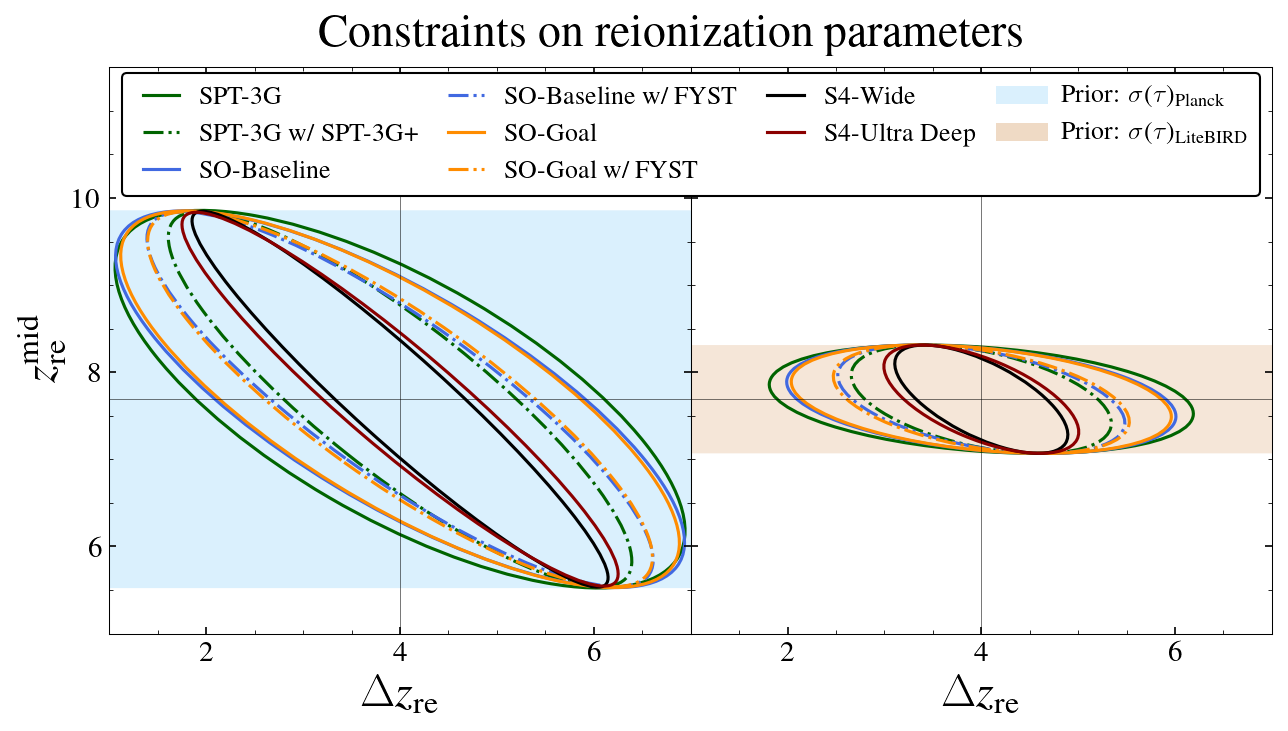

SystemExit: 

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3449: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [22]:
#Reionisation kSZ now

#read the Fisher matrix
fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ_TTEETE_3mJymask.npy'
parent_F_dict = np.load( fisher_fname, allow_pickle=True).item()
print(parent_F_dict.keys() ) #different lmax_TT


#experiment names and fsky values
expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 'so_goal', 'so_goal_withccatp', 's4_wide', 's4_deep']
#expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_goal', 's4_wide', 's4_deep']
exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black', '-'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred', '-'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen', '-'],
                  'spt4': ['SPT-3G w/ SPT-3G+', 0.03, 'darkgreen', '-.'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue', '-'],
                  'so_baseline_withccatp': ['SO-Baseline w/ FYST', 0.4, 'royalblue', '-.'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange', '-'],
                  'so_goal_withccatp': ['SO-Goal w/ FYST', 0.4, 'darkorange', '-.'], 
                  }


'''
fisher_fname = 'publish/fisher/F_mat_lcdm_foregrounds_allkSZ.npy'
#fisher_fname = 'publish/fisher/F_mat_results_reion.npy'
parent_F_dict = np.load( fisher_fname, allow_pickle=True).item()
'''
reqd_max_l_temp = 5000
reqd_max_l_temp_keyname = 'lmax_%s' %(reqd_max_l_temp)
F_dict = parent_F_dict[reqd_max_l_temp_keyname]

import camb
param_dict = tools_for_plotting.get_ini_param_dict()
#print(param_dict)
pars = camb.CAMBparams(max_l_tensor = param_dict['max_l_tensor'], max_eta_k_tensor = param_dict['max_eta_k_tensor'])
pars.set_accuracy(AccuracyBoost = param_dict['AccuracyBoost'], lAccuracyBoost = param_dict['lAccuracyBoost'], lSampleBoost = param_dict['lSampleBoost'],\
    DoLateRadTruncation = param_dict['do_late_rad_truncation'])
pars.set_cosmology(thetastar=param_dict['thetastar'], ombh2=param_dict['ombh2'], omch2=param_dict['omch2'], nnu = param_dict['neff'], mnu=param_dict['mnu'], \
    omk=param_dict['omk'], tau=param_dict['tau'], YHe = param_dict['YHe'], Alens = param_dict['Alens'], \
    num_massive_neutrinos = param_dict['num_nu_massive'])

zmid = camb.get_zre_from_tau(pars,param_dict['tau'])

color_arr = ['darkgreen', 'royalblue', 'darkred', 'black']
reqd_lmax_ksz = 5000
reqd_ilcname = 'cross-ILC'
fisher_keyname = (reqd_lmax_ksz, reqd_max_l_temp)
fix_params = ['mnu', 'neff', 'ws', 'Aksz']#, 'Acibtsz']#, 'alpha_radio', 'alpha_radio_sigma']
desired_params_to_plot = ['Aksz_h', 'alphaksz_h', 'zdur', 'zmid']
#reqd_expname_arr = ['spt3g', 'so_goal', 'spt4', 's4_wide']
reqd_expname_arr = expname_arr

clf()
fig = figure(figsize=(10., 5.))
subplots_adjust(wspace=0.)
fsval = 14
lwval = 1.5

prior_name_arr = [r'$\sigma(\tau)_{\rm Planck}$', r'$\sigma(\tau)_{\rm LiteBIRD}$']
prior_color_arr = ['lightskyblue', 'peru']
for iter in range(2): #Planck vs Litebird tau prior
    ax = subplot(1, 2, iter+1)
    print('\n##########################')
    #fix params
    if iter == 0:
        which_tau_prior = tau_prior_planck
        prior_spec_dict = {}
        prior_spec_dict['colorval'] = prior_color_arr[iter]
        prior_spec_dict['alphaval'] = 0.3
    else:
        which_tau_prior = tau_prior_litebird
        prior_spec_dict = {}
        prior_spec_dict['colorval'] = prior_color_arr[iter]
        prior_spec_dict['alphaval'] = 0.2

    prior_name = prior_name_arr[iter]
    print('\n Parameters fixed = %s' %(fix_params))
    prior_dic = {'tau': which_tau_prior,
                 'alpha_radio': spec_index_radio_prior, 
                 'alpha_radio_sigma': spec_index_radio_scatter_prior,
                 'Acibtsz': Acibtsz_prior,
                 'Aksz_h': Aksz_h_prior,
                 'alphaksz_h': alphaksz_h_prior,
                }
    
    if (1): #convert tau prior to zmid prior
        zmid_low = camb.get_zre_from_tau(pars,param_dict['tau'] - prior_dic['tau'])
        zmid_high = camb.get_zre_from_tau(pars,param_dict['tau'] + prior_dic['tau'])
        zmid_range = zmid_high - zmid_low
        zmid_range = round(zmid_range, 2)
        print( zmid, zmid_low, zmid_high, zmid_range )
        prior_dic['zmid'] = zmid_range
        #print(prior_dic['zmid'])
    

    color_dic = {}
    ls_dic = {}
    F_dic = {}
    reqd_expname_str_arr = []
    for cntr, expname in enumerate( reqd_expname_arr ):

        ##print(reqd_ilcname)
        F_mat, param_names = F_dict[expname][reqd_ilcname][fisher_keyname]
        F_mat_mod, param_names_mod = np.copy(F_mat), np.copy(param_names)
        ##print(F_mat_mod.shape, param_names_mod); sys.exit()

        #add priors.
        F_mat_mod = fisher_tools.add_priors(F_mat_mod, param_names_mod, prior_dic)
        #print('\t\tPriors set.')
        #print(F_mat_mod.shape)

        #fix desired parameters.
        F_mat_mod, param_names_mod = fisher_tools.fix_params(F_mat_mod, param_names_mod, fix_params)
        #print('\t\tUndesired parameters (%s) fixed.' %(fix_params))
        #print(F_mat_mod.shape, param_names_mod); sys.exit()

        expname_str = exp_specs_dict[expname][0]

        F_dic[expname_str] = F_mat_mod
        #color_dic[expname_str] = [exp_specs_dict[expname][2]]
        color_dic[expname_str] = [exp_specs_dict[expname][2]]
        color_dic[expname] = [exp_specs_dict[expname][2]]
        ls_dic[expname_str] = [exp_specs_dict[expname][3]]
        ls_dic[expname] = [exp_specs_dict[expname][3]]
        reqd_expname_str_arr.append( expname_str )    

    if (0):
        close('all')
        clf()
        tr, tc = tools_for_plotting.make_triangle_plot(reqd_expname_str_arr, F_dic, param_dict, param_names_mod, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fsval = 11, prior_dic = prior_dic)

        if tr > 2:
            ax = subplot(tr, tc, 3)
        else:
            ax = subplot(tr, tc, 2)    
        for tmpnamecntr, expname in enumerate( reqd_expname_arr ):
            plot([], [], color = color_dic[expname][0], label = r'%s' %(exp_specs_dict[expname][0]))

        prior_str = ''
        total_priors = 0
        for ppp in sorted(prior_dic):
            if ppp not in param_names_mod: continue
            #prior_str = '%s; $\sigma$(%s)=%s' %(prior_str, tools_for_plotting.get_latex_param_str(ppp), prior_dic_mod[ppp])
            if total_priors>3:
                prior_str = '%s;\n%s=%g' %(prior_str, tools_for_plotting.get_latex_param_str(ppp), prior_dic[ppp])
                total_priors =0
            else:
                prior_str = '%s; %s=%g' %(prior_str, tools_for_plotting.get_latex_param_str(ppp), prior_dic[ppp])
            total_priors += 1
        prior_str = prior_str.strip('; ')
        #plot([], [], 'k-.', label = r'Priors: %s' %(prior_str))
        legend(loc = 2, fontsize = 10, framealpha = 0.)
        axis('off')
        show(); sys.exit()
    else:
        desired_params_to_plot = ['zdur', 'zmid']
        fix_axis_range_to_xxsigma = None #3.
        #tr, tc = tools_for_plotting.make_triangle_plot(reqd_expname_arr, F_dic, param_dict, param_names_mod, desired_params_to_plot, color_dic, ls_dic = None, one_or_two_sigma = 1, fix_axis_range_to_xxsigma = fix_axis_range_to_xxsigma, fsval = 11, prior_dic = prior_dic_mod, show_diagonal = False)
        ax = tools_for_plotting.show_two_parameter_plot(ax, reqd_expname_str_arr, F_dic, param_dict, param_names_mod, desired_params_to_plot, color_dic, ls_dic = ls_dic, one_or_two_sigma = 1, fsval = fsval, fix_axis_range_to_xxsigma = fix_axis_range_to_xxsigma, lwval = lwval, prior_dic = prior_dic, prior_name = prior_name, prior_spec_dict=prior_spec_dict)
        p1, p2 = desired_params_to_plot
        p1str = tools_for_plotting.get_latex_param_str(p1)
        p2str = tools_for_plotting.get_latex_param_str(p2)
        xlabel(p1str, fontsize = fsval+8);
        if iter == 0:
            ylabel(p2str, fontsize = fsval+8);
        else:
            setp(ax.get_yticklabels(), visible=False)
        #axhline(param_dict[p2], lw = 0.2);axvline(param_dict[p1], lw = 0.2)
        ylim(5., 11.5)
            
if (1): #add legend
    
    suptitle(r'Constraints on reionization parameters', y = 0.95, fontsize = fsval+8)
    xloc, yloc = 0.201, .79
    #xloc, yloc = 0.19, .3
    #xloc, yloc = 0.1, 0.05
    w, h = 0.7, 0.1
    cax = fig.add_axes([xloc, yloc, w, h])
    for cntr, expname in enumerate( reqd_expname_arr ):
        expname_str, fskyval, colorval, lsval = exp_specs_dict[expname]
        plot([], [], color = colorval, lw = lwval, ls = lsval, label = r'%s' %(expname_str))
    for iter in range(2):
        axvspan(10., 10., color = prior_color_arr[iter], edgecolor = None, lw=0., alpha = 0.3, zorder = -1000, label = r'Prior: %s' %(prior_name_arr[iter]))
    leg=legend(loc = 1, fontsize = fsval-1.5, ncol = 4, columnspacing=0.8, framealpha=1., handletextpad=0.5)
    #leg.get_frame().set_edgecolor('gray')
    axis('off')

plname = 'plots/reionisation_constraints.pdf'
savefig(plname, dpi = 200.)
show(); 
sys.exit()
